---
title: "基于 Pytorch 的线性回归和逻辑回归"
date: 2025-05-05T21:40:32+08:00
author: "Liu Zheng"
tags: ["笔记", "实验"]
categories: ["实验笔记"]
---

## 基于 Pytorch 的线性回归和逻辑回归

In [1]:
import torch
import numpy
import matplotlib.pyplot
import pandas

matplotlib.pyplot.style.use("matplotlib.mplstyle")

DEVICE = torch.device('cuda:0')

### 一元线性回归构建

In [2]:
DATASET = pandas.read_csv("./202501061035.csv")

X = (DATASET[["size", "rooms"]]).astype(float).to_numpy()
Y = (DATASET["price"]).astype(float).to_numpy()

X[:, 0] = X[:, 0] / 1000
Y = Y / 1000

X = torch.from_numpy(X).type(torch.float32).to(DEVICE)
Y = torch.from_numpy(Y).type(torch.float32).to(DEVICE).unsqueeze(1)

In [3]:
# 定义线性回归模型
MODEL = torch.nn.Linear(in_features=1, out_features=1).to(DEVICE)

# 定义损失函数和优化器
CRITERION = torch.nn.MSELoss()
OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=0.01)

# 手动训练
HISTORY = []
EPOCHS = 200
for epoch in range(EPOCHS):
    pred = MODEL(X[:, 0].unsqueeze(1)) # 前向传播
    loss = CRITERION(pred, Y)          # 损失计算
    OPTIMIZER.zero_grad()              # 清除梯度
    loss.backward()                    # 计算梯度
    OPTIMIZER.step()                   # 更新参数
    if (epoch + 1) % 10 == 0:
        dict = MODEL.state_dict()
        fw = dict["weight"].cpu().detach().numpy()
        fb = dict["bias"].cpu().detach().numpy()
        HISTORY.append([fw[0][0], fb[0], loss.item()])
        print(f"Cost is {loss:.4e}, Weights is {fw[0][0]:.4e}, Bias is {fb[0]:.4e}")

HISTORY = torch.from_numpy(numpy.array(HISTORY)).type(torch.float32)

DICT = MODEL.state_dict()
FW = dict["weight"].cpu().detach().numpy()
FB = dict["bias"].cpu().detach().numpy()

Cost is 1.9736e+04, Weights is 9.5767e+01, Bias is 4.1846e+01
Cost is 5.6412e+03, Weights is 1.2548e+02, Bias is 5.5305e+01
Cost is 4.2755e+03, Weights is 1.3467e+02, Bias is 5.9645e+01
Cost is 4.1427e+03, Weights is 1.3746e+02, Bias is 6.1143e+01
Cost is 4.1294e+03, Weights is 1.3826e+02, Bias is 6.1754e+01
Cost is 4.1276e+03, Weights is 1.3845e+02, Bias is 6.2086e+01
Cost is 4.1270e+03, Weights is 1.3845e+02, Bias is 6.2327e+01
Cost is 4.1265e+03, Weights is 1.3839e+02, Bias is 6.2537e+01
Cost is 4.1261e+03, Weights is 1.3831e+02, Bias is 6.2735e+01
Cost is 4.1257e+03, Weights is 1.3823e+02, Bias is 6.2926e+01
Cost is 4.1252e+03, Weights is 1.3815e+02, Bias is 6.3111e+01
Cost is 4.1249e+03, Weights is 1.3807e+02, Bias is 6.3293e+01
Cost is 4.1245e+03, Weights is 1.3799e+02, Bias is 6.3470e+01
Cost is 4.1241e+03, Weights is 1.3791e+02, Bias is 6.3643e+01
Cost is 4.1238e+03, Weights is 1.3783e+02, Bias is 6.3813e+01
Cost is 4.1234e+03, Weights is 1.3776e+02, Bias is 6.3979e+01
Cost is 

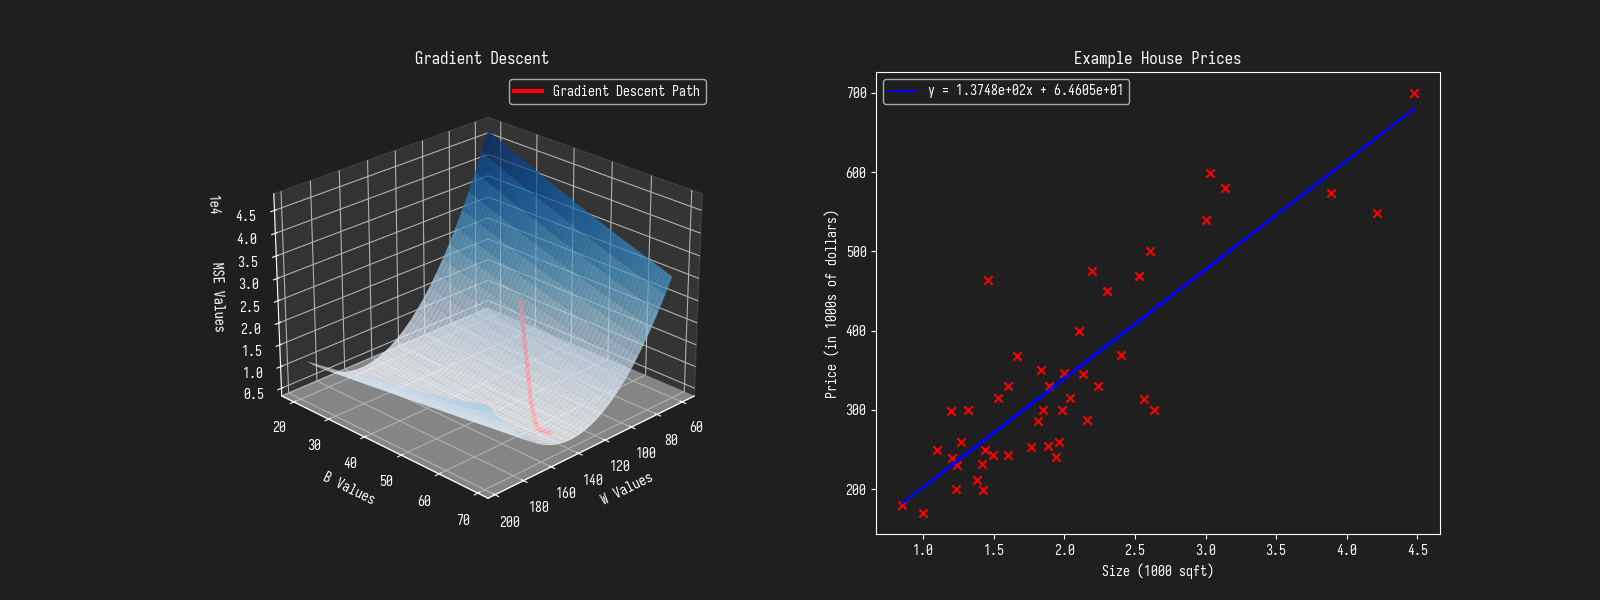

In [4]:
%config InlineBackend.print_figure_kwargs = {"bbox_inches": None}

W = torch.arange(60, 200, 5).type(torch.float32).to(DEVICE)
B = torch.arange(20, 70, 1).type(torch.float32).to(DEVICE)
W, B = torch.meshgrid(W, B, indexing='xy')

def compute_cost(w, b):
    costs = []
    for i in range(w.shape[0]):
        predictions = w[i] * X[:, 0].unsqueeze(1) + b[i]
        costs.append(CRITERION(predictions, Y))
    return torch.stack(costs)

Z = torch.vmap(compute_cost, in_dims=(0, 0))(W, B)

X = X.cpu().detach().numpy()
Y = Y.cpu().detach().numpy()
W = W.cpu().detach().numpy()
B = B.cpu().detach().numpy()
Z = Z.cpu().detach().numpy()

figure = matplotlib.pyplot.figure(figsize=(16, 6))
axes1 = figure.add_subplot(1, 2, 1, projection="3d")
surface = axes1.plot_surface(W, B, Z, cmap=matplotlib.cm.Blues, alpha=0.75)

axes1.view_init(elev=25, azim=45, roll=0)
axes1.set_title("Gradient Descent")
axes1.set_xlabel("W Values")
axes1.set_ylabel("B Values")
axes1.set_zlabel("MSE Values")
axes1.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
axes1.plot3D(HISTORY[:, 0], HISTORY[:, 1], HISTORY[:, 2], color="red", linewidth=3, label="Gradient Descent Path")
axes1.legend()

axes2 = figure.add_subplot(1, 2, 2)

axes2.scatter(X[:, 0], Y, marker="x", c="r")
axes2.plot(X[:, 0], FW[0][0] * X[:, 0] + FB[0], color="blue", label=f"y = {FW[0][0]:.4e}x + {FB[0]:.4e}")
axes2.set_title("Example House Prices")
axes2.set_xlabel("Size (1000 sqft)")
axes2.set_ylabel("Price (in 1000s of dollars)")
axes2.legend()

matplotlib.pyplot.show()

### 一元逻辑回归构建

In [5]:
DATASET = pandas.read_csv("./202503081558.csv")

X = (DATASET[["C1", "C2"]]).astype(float).to_numpy()
Y = (DATASET["LABEL"]).astype(float).to_numpy()

X = X / 100

X = torch.from_numpy(X).float().to(DEVICE)
Y = torch.from_numpy(Y).unsqueeze(1).float().to(DEVICE)

print(f"X shape is {X.shape}, Y shape is {Y.shape}")

X shape is torch.Size([100, 2]), Y shape is torch.Size([100, 1])


In [6]:
# 定义逻辑回归模型
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
MODEL = LogisticRegression().to(DEVICE)

# 定义损失函数和优化器
CRITERION = torch.nn.BCELoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=0.2)


# 手动训练
HISTORY = []
EPOCHS = 1000
for epoch in range(EPOCHS):
    pred = MODEL(X) # 前向传播
    loss = CRITERION(pred, Y) # 损失计算
    OPTIMIZER.zero_grad() # 清除梯度
    loss.backward() # 计算梯度
    OPTIMIZER.step() # 更新参数
    if (epoch + 1) % 10 == 0:
        dict = MODEL.state_dict()
        fw = dict["linear.weight"].cpu().detach().numpy()
        fb = dict["linear.bias"].cpu().detach().numpy()
        HISTORY.append([fw[0][0], fw[0][1], fb[0], loss.item()])

print(pandas.DataFrame(HISTORY, columns=["WEIGHT0", "WEIGHT1", "BIAS", "LOSS"]).to_string(formatters={'WEIGHT0': '{:.4e}'.format, 'WEIGHT1': '{:.4e}'.format, 'BIAS': '{:.4e}'.format, 'LOSS': '{:.4e}'.format}))

HISTORY = torch.from_numpy(numpy.array(HISTORY)).float()



      WEIGHT0    WEIGHT1        BIAS       LOSS
0  4.7308e-01 5.9527e-01  3.9539e-01 6.9357e-01
1  6.2777e-01 5.6325e-01 -5.1538e-01 6.2650e-01
2  1.4115e+00 1.1820e+00 -9.4699e-01 5.7458e-01
3  1.8809e+00 1.4886e+00 -1.7671e+00 5.3012e-01
4  2.5490e+00 2.0379e+00 -2.3918e+00 4.9123e-01
5  3.0825e+00 2.4837e+00 -3.1218e+00 4.5757e-01
6  3.6391e+00 2.9899e+00 -3.7732e+00 4.2866e-01
7  4.1412e+00 3.4676e+00 -4.4163e+00 4.0398e-01
8  4.6135e+00 3.9343e+00 -5.0252e+00 3.8293e-01
9  5.0624e+00 4.3888e+00 -5.5963e+00 3.6493e-01
10 5.4790e+00 4.8161e+00 -6.1441e+00 3.4948e-01
11 5.8796e+00 5.2289e+00 -6.6572e+00 3.3613e-01
12 6.2573e+00 5.6176e+00 -7.1479e+00 3.2453e-01
13 6.6197e+00 5.9893e+00 -7.6124e+00 3.1438e-01
14 6.9659e+00 6.3428e+00 -8.0559e+00 3.0545e-01
15 7.2980e+00 6.6802e+00 -8.4793e+00 2.9754e-01
16 7.6171e+00 7.0033e+00 -8.8842e+00 2.9050e-01
17 7.9237e+00 7.3129e+00 -9.2728e+00 2.8420e-01
18 8.2191e+00 7.6106e+00 -9.6458e+00 2.7852e-01
19 8.5037e+00 7.8971e+00 -1.0005e+01 2.7

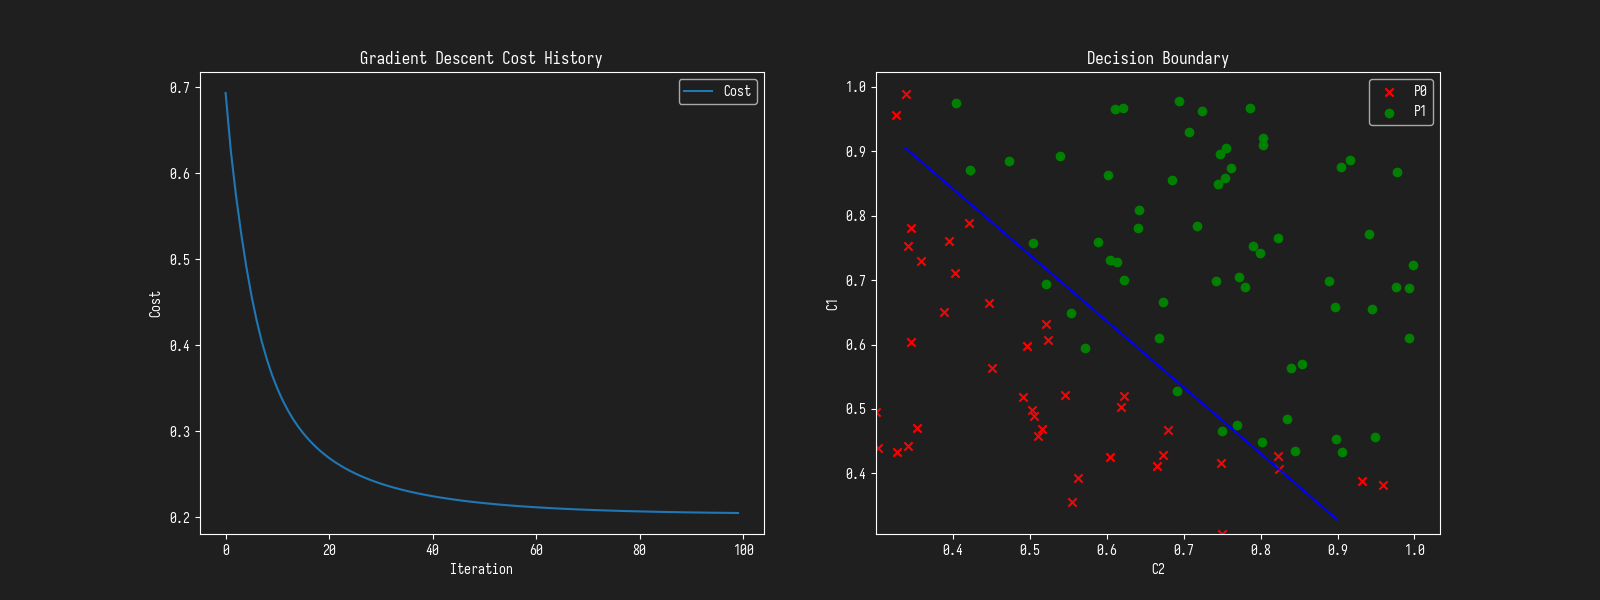

In [7]:
figure = matplotlib.pyplot.figure(figsize=(16, 6))
axes1 = figure.add_subplot(1, 2, 1)
axes1.plot(HISTORY[:, 3], label="Cost")
axes1.set_title("Gradient Descent Cost History")
axes1.set_ylabel("Cost")
axes1.set_xlabel("Iteration")
axes1.legend()

X = X.cpu().detach().numpy()
Y = Y.cpu().detach().numpy()

XMIN1, XMAX1 = X[:, 0].min(), X[:, 0].max()
XMIN2, XMAX2 = X[:, 1].min(), X[:, 1].max()
XX1, XX2 = torch.meshgrid(torch.arange(XMIN1, XMAX1, 0.1), torch.arange(XMIN2, XMAX2, 0.1), indexing="xy")
GRID = torch.stack([XX1, XX2], axis=-1).reshape(-1, 2).to(DEVICE)

with torch.no_grad():
    PROBS = MODEL.forward((GRID).squeeze())

PROBS = PROBS.cpu().detach().numpy()

MASK0 = (Y == 0).squeeze() # 布尔掩码 Y = 0
MASK1 = (Y == 1).squeeze() # 布尔掩码 Y = 1

axes2 = figure.add_subplot(1, 2, 2)
axes2.scatter(X[MASK0, 0], X[MASK0, 1], marker="x", c="r", label="P0")
axes2.scatter(X[MASK1, 0], X[MASK1, 1], marker="o", c="g", label="P1")
axes2.contour(XX1, XX2, PROBS.reshape(7, 7), levels=[0.5], colors="b")
axes2.set_title("Decision Boundary")
axes2.set_ylabel("C1")
axes2.set_xlabel("C2")
axes2.legend()

matplotlib.pyplot.show()

In [8]:
features = [50.534788289883 / 100, 48.85581152764205 / 100]
SAMPLE = torch.from_numpy(numpy.array(features)).float().to(DEVICE)

with torch.no_grad():
    label = MODEL(SAMPLE).item()

print(f"Logistic for {features[0]} C1 and {features[1]} C2 is Label: {label}")

Logistic for 0.5053478828988299 C1 and 0.48855811527642046 C2 is Label: 0.012737162411212921
